Loading model...
✅ Model loaded successfully. Features used: ['log_amount', 'amount_over_payer_mean', 'payer_device_count', 'txn_count_by_payer', 'hour', 'dayofweek', 'is_weekend']
Loading dataset...
✅ Dataset loaded: 7953 rows

⚙️ Auto-adjusted fraud threshold: 0.250

🚀 Starting Real-Time Fraud Detection Stream...

TIME                | TXN_ID   | AMOUNT   | PROB   | STATUS
------------------------------------------------------------
18:21:16 | 00000001 | ₹  1,262.77 | 0.142 | LEGIT
18:21:16 | 00000002 | ₹  2,222.93 | 0.162 | LEGIT
18:21:16 | 00000003 | ₹       nan | 0.051 | LEGIT
18:21:16 | 00000004 | ₹  2,782.96 | 0.187 | LEGIT
18:21:17 | 00000005 | ₹      0.00 | 0.231 | LEGIT
18:21:17 | 00000006 | ₹  8,526.01 | 0.185 | LEGIT
18:21:17 | 00000007 | ₹       nan | 0.053 | LEGIT
18:21:17 | 00000008 | ₹  9,396.35 | 0.218 | LEGIT
18:21:18 | 00000009 | ₹       nan | 0.107 | LEGIT
18:21:18 | 00000010 | ₹      0.00 | 0.629 | FRAUD
18:21:18 | 00000011 | ₹      0.00 | 0.153 | LEGIT
18:21:18 | 

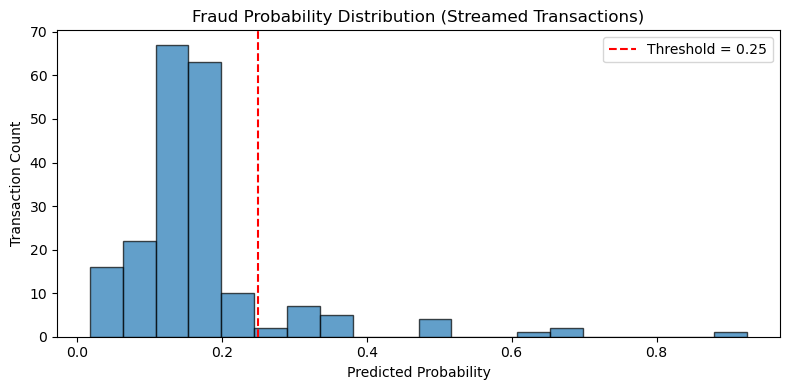

In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
from datetime import datetime
import random
import csv
import os
import matplotlib.pyplot as plt

# ================================
# 🔧 CONFIGURATION
# ================================
DATASET_PATH = "Updated_Inclusive_Indian_Online_Scam_Dataset (1) (1).csv"
MODEL_PATH = "model/lightgbm_model.txt"
STREAM_DELAY = 0.2       # seconds between each transaction (faster)
SUSPICIOUS_RATIO = 0.15  # fraction of transactions made suspicious (15%)
LOG_FILE = "fraud_stream_log.csv"
# ================================


# ================================
# 🧠 LOAD MODEL
# ================================
print("Loading model...")
model = lgb.Booster(model_file=MODEL_PATH)
feature_cols = model.feature_name()
print(f"✅ Model loaded successfully. Features used: {feature_cols}")


# ================================
# 📂 LOAD DATASET
# ================================
print("Loading dataset...")
df = pd.read_csv(DATASET_PATH)
print(f"✅ Dataset loaded: {df.shape[0]} rows\n")


# ================================
# 🧮 FEATURE ENGINEERING
# ================================
def preprocess_row(row):
    """Extracts and computes all required model features for one transaction."""
    amount = float(row.get("amount", 0.0)) if not pd.isnull(row.get("amount", 0.0)) else 0.0
    log_amount = np.log1p(amount)

    # Handle transaction_time if exists, else assume current time
    try:
        t = pd.to_datetime(row.get("transaction_time"), errors="coerce")
        if pd.isnull(t):
            t = datetime.now()
    except Exception:
        t = datetime.now()

    hour = t.hour
    dayofweek = t.weekday()
    is_weekend = 1 if dayofweek >= 5 else 0

    return {
        "log_amount": log_amount,
        "amount_over_payer_mean": row.get("amount_over_payer_mean", 1.0),
        "payer_device_count": row.get("payer_device_count", 1),
        "txn_count_by_payer": row.get("txn_count_by_payer", 1),
        "hour": hour,
        "dayofweek": dayofweek,
        "is_weekend": is_weekend
    }


# ================================
# ⚠️ MAKE TRANSACTION SUSPICIOUS
# ================================
def make_suspicious(features):
    """Artificially modifies a transaction to look fraudulent for simulation."""
    features["log_amount"] *= random.uniform(3, 10)
    features["amount_over_payer_mean"] *= random.uniform(5, 20)
    features["payer_device_count"] = random.randint(1, 2)
    features["txn_count_by_payer"] = random.randint(1, 3)
    return features


# ================================
# 🎯 AUTO THRESHOLD CALIBRATION
# ================================
sample_features = df.head(500).apply(preprocess_row, axis=1)
X_sample = np.array([[x[c] for c in feature_cols] for x in sample_features])
sample_probs = model.predict(X_sample)

auto_threshold = max(0.25, np.percentile(sample_probs, 85))  # Top 15% considered FRAUD
print(f"⚙️ Auto-adjusted fraud threshold: {auto_threshold:.3f}\n")


# ================================
# 💾 LOGGING SETUP
# ================================
if os.path.exists(LOG_FILE):
    os.remove(LOG_FILE)

with open(LOG_FILE, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["timestamp", "transaction_id", "amount", "probability", "status"] + feature_cols)


# ================================
# 🔄 STREAM GENERATOR
# ================================
def stream_transactions(df):
    """Yields preprocessed transactions (some randomly made suspicious)."""
    for idx, row in df.iterrows():
        features = preprocess_row(row)
        if random.random() < SUSPICIOUS_RATIO:
            features = make_suspicious(features)
        yield idx, features


# ================================
# 🚀 REAL-TIME STREAMING LOOP
# ================================
print("🚀 Starting Real-Time Fraud Detection Stream...\n")
print(f"{'TIME':19} | {'TXN_ID':8} | {'AMOUNT':8} | {'PROB':6} | STATUS")
print("-" * 60)

for idx, features in stream_transactions(df.head(200)):  # First 200 transactions
    X = np.array([[features[c] for c in feature_cols]])
    prob = float(model.predict(X)[0])
    label = "FRAUD" if prob >= auto_threshold else "LEGIT"
     # ✅ Safely convert log_amount to rupee amount
    try:
        actual_amount = np.expm1(float(features["log_amount"]))
    except (ValueError, OverflowError, TypeError):
        actual_amount = np.nan  # If conversion fails

    # ✅ Cap unrealistic amounts (greater than ₹1 crore or negative)
    if np.isnan(actual_amount) or actual_amount < 0 or actual_amount > 1e7:
        actual_amount = np.nan  # or use: actual_amount = 1e7 if you want to cap it

    # ✅ Print formatted output neatly
    print(f"{datetime.now().strftime('%H:%M:%S')} | {idx+1:08d} | ₹{actual_amount:10,.2f} | {prob:.3f} | {label}")

    # Log to CSV
    with open(LOG_FILE, "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([
            datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            f"TXN_{idx+1}",
            round(np.expm1(features["log_amount"]), 2),
            round(prob, 4),
            label
        ] + [features[c] for c in feature_cols])

    time.sleep(STREAM_DELAY)

print("\n✅ Real-time streaming simulation completed successfully!")
print(f"📁 Results saved to: {LOG_FILE}")

# ================================
# 📈 OPTIONAL: PROBABILITY VISUALIZATION
# ================================
probs = pd.read_csv(LOG_FILE)["probability"]
plt.figure(figsize=(8, 4))
plt.hist(probs, bins=20, alpha=0.7, edgecolor="black")
plt.axvline(auto_threshold, color="red", linestyle="--", label=f"Threshold = {auto_threshold:.2f}")
plt.title("Fraud Probability Distribution (Streamed Transactions)")
plt.xlabel("Predicted Probability")
plt.ylabel("Transaction Count")
plt.legend()
plt.tight_layout()
plt.show()
